## Импорты и используемые файлы

In [264]:
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency

diabetes = pd.read_csv('data/diabetes.csv', sep=',')
train = pd.read_csv('data/train.csv', sep=',')
test = pd.read_csv('data/test.csv', sep=',')
dia_1 = pd.read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv', sep=',')
dia_2 = pd.read_csv('data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv', sep=',')
dia_3 = pd.read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv', sep=',')

## Блок с функциями

In [265]:
def change_0 (meaning: float) -> float | None:
    """Заменить 0 на None, остальные данные не трогать"""
    if meaning == 0:
        return None
    else:
        return meaning
    
def get_bp(bp: float) -> int:
    """1 - наличие АГ, 0 - отсутствие АГ"""
    if bp >= 90:
        return 1
    else:
        return 0
    
def get_obesity(bmi: float) -> int:
    """1 - наличие ожирения, 0 - отсутствие ожирения"""
    if bmi >= 30:
        return 1
    else:
        return 0

## Датасет __diabetes__ 



В таблице diabetes собраны данные о 768 женщинах индейского происхождения Пима в возрасте от 21 до 81 лет, у которых измеряли ИМТ, ДАД, толщину кожной складки трицепса, глюкозу через 2 часа в ПГТТ, инсулин; отразили наследственность по диабету и количество беременностей.

### Обработка данных diabetes
 
Пропущенных значений, на первый взгляд, нет. Однако, при описании каждого из столбцов встречается 0 в min: уровень глюкозы, уровень ДАД, толщина кожной складки трицепса, инсулин, ИМТ. Такого в живом организме быть не может, а значение 0 может повлиять на общие выводы. Допускаем, что число беременностей может быть 0, поэтому это значение меня относительно устраивает. Создам столбец, который отражает наличие/отсуствие АГ, т.к. нам дано только ДАД, диагноз буду ставить по уровню ДАД. Переименую столбцы для последующей конкатенации, также для этого создам столбец Sex. Выделю столбец HighParity, в котором 1 - это наличие 3 и более беременностей, что не очень корректно, потому паритет - это количество родов.  

In [266]:
diabetes['Glucose'] = diabetes['Glucose'].apply(change_0)
diabetes ['BloodPressure'] = diabetes['BloodPressure'].apply(change_0)
diabetes['SkinThickness'] = diabetes['SkinThickness'].apply(change_0)
diabetes['Insulin'] = diabetes['Insulin'].apply(change_0)
diabetes['BMI'] = diabetes['BMI'].apply(change_0)

diabetes = diabetes.rename(columns={'Outcome' : 'Diabetes'})

diabetes['HighBP'] = diabetes['BloodPressure'].apply(get_bp)
diabetes['Sex'] = [0] * 768
diabetes['HighParity'] = diabetes['Pregnancies'].apply(lambda x: 0 if x < 3 else 1)
diabetes['Obesity'] = diabetes['BMI'].apply(get_obesity)

### Блок расчета p и χ² для diabetes
Предположим, что фактором риска развития сахарного диабета является: факт высокого паритета, факт высокого АД, факт ожирения.

In [267]:
chi2, p, dof, expected = chi2_contingency(pd.crosstab(diabetes['HighBP'], diabetes['Diabetes']))
display(f'χ²: {chi2}, p-значение: {p}')

chi2, p, dof, expected = chi2_contingency(pd.crosstab(diabetes['HighParity'], diabetes['Diabetes']))
display(f'χ²: {chi2}, p-значение: {p}')

chi2, p, dof, expected = chi2_contingency(pd.crosstab(diabetes['Obesity'], diabetes['Diabetes']))
display(f'χ²: {chi2}, p-значение: {p}')

'χ²: 4.551191702504427, p-значение: 0.03289584329913219'

'χ²: 28.784292119287443, p-значение: 8.090462947728804e-08'

'χ²: 70.01243027191117, p-значение: 5.893192387193184e-17'

### Выводы по датасету diabetes
Существует статистически значимая связь между АГ в анамнезе (p < 0.05), наличием ожирения (p < 0.05), высоким паритетом (p < 0.05) и СД.

## Датасеты __train__ и __test__ 

В таблицах собраны данные о более чем 4000 жителей города Фрамингем, штат Массачусетс. У жителей исследовали: возраст, уровень образования, пол, факт курения, количество выкуриваемых сигарет в день, факт инсульта, факт АГ, факт СД, уровень холестерина, САД, ДАД, ИМТ, ЧСС, уровень глюкозы. 

### Обработка данных и объединение train и test

В test 16 колонок, 848 строк. В train 17 колонок, 3390 строк. Одним и тем же параметрам соответствуют колонки: все, кроме TenYearCHD. Таблицы можно объединить горизонтально, по строкам. Общее количество строк должно быть 4238.
Столбец риска развития ИБС есть только в датасете train, это расчетный показатель и при объединении 848 id будут без этого значения. Я удалю этот столбец, принимая во внимание то, что нас интересуют факторы риска СД, а сердечно-сосудистый риск.
Проанализируем данные на предмет пропущенных значений, для этого посмотрим на min. min == 0 у приемлемых показателей. 
Появились новые факты, которые можно отнести к факторам риска диабета: уровень образования, пол, факт курения, факт инсульта, уровень холестерина, САД, ЧСС. Колонку BPMeds (медицинские данные), возможно удалю ее, не понимаю, какую информацию она несет, 
Переименую колонки с одинаковыми данными, но разными названиями, для последующей конкатенации. А также создам столбец, который отражает факт наличия/отсутствия АГ. Заменю male на 1, а female на 0 исходя из данных по следующему датасету (https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook/notebook).



In [268]:
train_test = pd.concat([train, test], axis=0)

train_test = train_test.drop('TenYearCHD', axis=1)

train_test = train_test.rename(columns={'sex' : 'Sex', 'age' : 'Age', 'diabetes' : 'Diabetes'})

train_test['HighBP'] = train_test['diaBP'].apply(get_bp)
train_test['Sex'] = train_test['Sex'].apply(lambda x: 0 if x == 'F' else 1)
train_test['Obesity'] = train_test['BMI'].apply(get_obesity)

In [269]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4238 entries, 0 to 847
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4238 non-null   int64  
 1   Age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   Sex              4238 non-null   int64  
 4   is_smoking       4238 non-null   object 
 5   cigsPerDay       4209 non-null   float64
 6   BPMeds           4185 non-null   float64
 7   prevalentStroke  4238 non-null   int64  
 8   prevalentHyp     4238 non-null   int64  
 9   Diabetes         4238 non-null   int64  
 10  totChol          4188 non-null   float64
 11  sysBP            4238 non-null   float64
 12  diaBP            4238 non-null   float64
 13  BMI              4219 non-null   float64
 14  heartRate        4237 non-null   float64
 15  glucose          3850 non-null   float64
 16  HighBP           4238 non-null   int64  
 17  Obesity          423

### Блок расчета p и χ² для train_test

In [270]:
chi2, p, dof, expected = chi2_contingency(pd.crosstab(train_test['HighBP'], train_test['Diabetes']))
display(f'χ²: {chi2}, p-значение: {p}')

chi2, p, dof, expected = chi2_contingency(pd.crosstab(train_test['Obesity'], train_test['Diabetes']))
display(f'χ²: {chi2}, p-значение: {p}')

'χ²: 8.797110616985364, p-значение: 0.0030170799467614216'

'χ²: 18.17389616350793, p-значение: 2.01623518636905e-05'

### Выводы по датасету train_test

Существует статистически значимая связь между АГ в анамнезе (p < 0.05), наличием ожирения (p < 0.05) и СД.


## __Датасеты__ diabetes_012_health_indicators_BRFSS2015 __(dia_1)__, diabetes_binary_5050split_health_indicators_BRFSS2015 __(dia_2)__, diabetes_012_health_indicators_BRFSS2015 __(dia_3)__ 

В таблицах собраны данные о более чем 400 000 жителей США. В ходе телефонного опроса у жителей узнавали: возраст, уровень образования, уровень дохода, пол, факт курения, факт инсульта, факт ИМ или ИБС, факт АГ, факт СД, факт проверки уровня холестерина, факт высокого уровня холестерина, ИМТ, факт физической активности за последние 30 дней, факт употребления фруктов и отдельно овощей хотя бы 1 раз в день.

### Обработка данных и объединение трех датасетов
В таблицах dia_1 и dia_3 диабет интерпретирован так: 0 - нет, 1 - диабет, 2 - преддиабет. А в таблице dia_2 этот показатель бинарный и преддиабет это 1, нужно заменить 2 на 1. Переименую столбцы, которые отражают одни и те же данные, но называются по-другому, для беспроблемной конкатенации. Диагноз АГ буду ставить по ДАД.


In [271]:
dia_2 = dia_2.rename(columns={'Diabetes_binary' : 'Diabetes_012'})

dia_1['Diabetes_012'] = dia_1['Diabetes_012'].apply(lambda x: 1 if x == 2 else x)
dia_3['Diabetes_012'] = dia_3['Diabetes_012'].apply(lambda x: 1 if x == 2 else x)

dia_all = pd.concat(
    [dia_1, dia_2, dia_3],
    ignore_index=True
)

dia_all = dia_all.rename(columns={'Diabetes_012': 'Diabetes'})
dia_all['Obesity'] = dia_all['BMI'].apply(get_obesity)

In [272]:
#Создам маски таблиц с общими столбцами для всех трех таблиц и объединю таблицы

mask_1 = diabetes.loc[:, ['Age', 'Sex', 'HighBP', 'Diabetes', 'BMI']]
mask_2 = dia_all.loc[:, ['Age', 'Sex', 'HighBP', 'Diabetes', 'BMI']]
mask_3 = train_test.loc[:, ['Age', 'Sex', 'HighBP', 'Diabetes', 'BMI']]

general_dataset = pd.concat(
    [mask_1, mask_2, mask_3],
    ignore_index=True
)

In [273]:
dia_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578052 entries, 0 to 578051
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes              578052 non-null  float64
 1   HighBP                578052 non-null  float64
 2   HighChol              578052 non-null  float64
 3   CholCheck             578052 non-null  float64
 4   BMI                   578052 non-null  float64
 5   Smoker                578052 non-null  float64
 6   Stroke                578052 non-null  float64
 7   HeartDiseaseorAttack  578052 non-null  float64
 8   PhysActivity          578052 non-null  float64
 9   Fruits                578052 non-null  float64
 10  Veggies               578052 non-null  float64
 11  HvyAlcoholConsump     578052 non-null  float64
 12  AnyHealthcare         578052 non-null  float64
 13  NoDocbcCost           578052 non-null  float64
 14  GenHlth               578052 non-null  float64
 15  

### Блок расчетов для general_dataset

In [274]:
chi2, p, dof, expected = chi2_contingency(pd.crosstab(general_dataset['HighBP'], general_dataset['Diabetes']))
display(f'χ²: {chi2}, p-значение: {p}')

chi2, p, dof, expected = chi2_contingency(pd.crosstab(general_dataset['Sex'], general_dataset['Diabetes']))
display(f'χ²: {chi2}, p-значение: {p}')

'χ²: 51706.425221904705, p-значение: 0.0'

'χ²: 636.7890000263055, p-значение: 1.668355168787208e-140'

In [275]:
general_dataset.corr()

,Age,Sex,HighBP,Diabetes,BMI
Age,1.000000,-0.022960,0.190117,0.106468,-0.040911
Sex,-0.022960,1.000000,0.052347,0.033052,0.037613
HighBP,0.190117,0.052347,1.000000,0.297799,0.222602
Diabetes,0.106468,0.033052,0.297799,1.000000,0.245962
BMI,-0.040911,0.037613,0.222602,0.245962,1.000000


# Итоговые выводы

На основе корреляционного анализа установлено, что я не умею его делать и у диабета нет взаимосвязи ни с одним из столбцов. 


# Визуализация

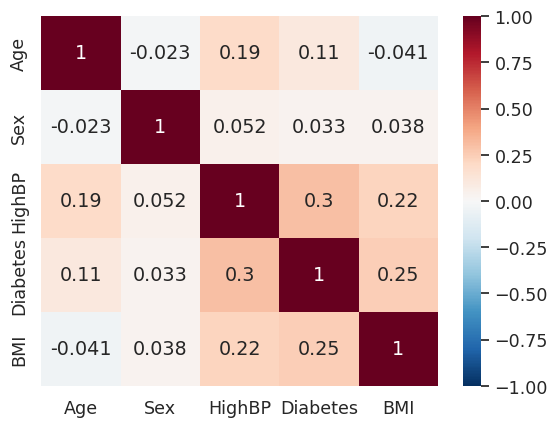

In [276]:
# Heatmap по матрице корреляций

sns.heatmap(
    general_dataset.corr(),        
    cmap='RdBu_r', 
    annot=True, # рисует значения внутри ячеек
    vmin=-1, vmax=1); # указывает начало цветовых кодов от -1 до 1.

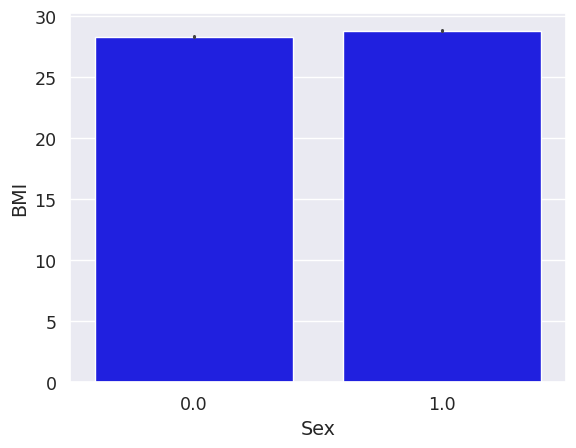

In [277]:
# Гистограмма для сравнения распределения ИМТ между мужчинами и женщинами

sns.barplot(
    x='Sex', 
    y='BMI', 
    data=general_dataset, 
    color='blue'
    );